In [1]:
include("ultrasoundgeneration.jl")

longcat (generic function with 1 method)

In [2]:
using PyCall
pushfirst!(PyVector(pyimport("sys")."path"), "")
ultrasoundgeneration = pyimport("ultrasoundgeneration")

names = readdir(ultrasoundgeneration.train_volumes_path)[1:30]

30-element Array{String,1}:
 "Pancreas_14.nrrd"
 "Pancreas_15.nrrd"
 "Pancreas_16.nrrd"
 "Pancreas_17.nrrd"
 "Pancreas_18.nrrd"
 "Pancreas_19.nrrd"
 "Pancreas_20.nrrd"
 "Pancreas_21.nrrd"
 "Pancreas_22.nrrd"
 "Pancreas_23.nrrd"
 "Pancreas_24.nrrd"
 "Pancreas_25.nrrd"
 "Pancreas_26.nrrd"
 ⋮                 
 "Pancreas_32.nrrd"
 "Pancreas_33.nrrd"
 "Pancreas_34.nrrd"
 "Pancreas_35.nrrd"
 "Pancreas_36.nrrd"
 "Pancreas_37.nrrd"
 "Pancreas_38.nrrd"
 "Pancreas_39.nrrd"
 "Pancreas_40.nrrd"
 "Pancreas_41.nrrd"
 "Pancreas_42.nrrd"
 "Pancreas_43.nrrd"

In [3]:
struct AnnotatedImage
    image::ItkImage
    annotation::Array{Array{Float64,1},1}
end


annotated_images = Array{AnnotatedImage, 1}()
for name = names
    print(name)
    image, annotation = ultrasoundgeneration.load_image_annotation(
        name, ultrasoundgeneration.train_volumes_path)
    jimage = ItkImage(image)
    push!(annotated_images, AnnotatedImage(jimage, annotation))
end

Pancreas_14.nrrdPancreas_15.nrrdPancreas_16.nrrdPancreas_17.nrrdPancreas_18.nrrdPancreas_19.nrrdPancreas_20.nrrdPancreas_21.nrrdPancreas_22.nrrdPancreas_23.nrrdPancreas_24.nrrdPancreas_25.nrrdPancreas_26.nrrdPancreas_27.nrrdPancreas_28.nrrdPancreas_29.nrrdPancreas_30.nrrdPancreas_31.nrrdPancreas_32.nrrdPancreas_33.nrrdPancreas_34.nrrdPancreas_35.nrrdPancreas_36.nrrdPancreas_37.nrrdPancreas_38.nrrdPancreas_39.nrrdPancreas_40.nrrdPancreas_41.nrrdPancreas_42.nrrdPancreas_43.nrrd

In [8]:
t_annotated_images = Array{AnnotatedImage, 1}()
for name = readdir(ultrasoundgeneration.test_volumes_path)
    print(name)
    image, annotation = ultrasoundgeneration.load_image_annotation(
        name, ultrasoundgeneration.test_volumes_path)
    jimage = ItkImage(image)
    push!(t_annotated_images, AnnotatedImage(jimage, annotation))
end

Pancreas_10.nrrdPancreas_11.nrrdPancreas_12.nrrdPancreas_13.nrrdPancreas_6.nrrdPancreas_7.nrrdPancreas_8.nrrdPancreas_9.nrrd

In [9]:
i = 0

0

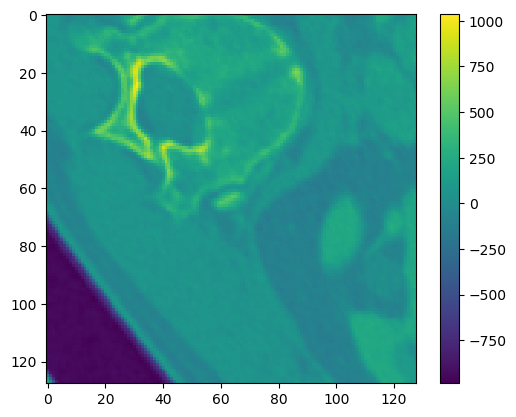

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbc42b557b8>

In [10]:
using PyPlot
i += 1
t = generate_sample(annotated_images[i].image, annotated_images[i].annotation)
plt.imshow(t["data"][1])
colorbar()


In [11]:
network_parallel = pyimport("train_network_withangle_oneprobe")


PyObject <module 'train_network_withangle_oneprobe' from '/media/data/hastings/ct-angledslice-align/train_network_withangle_oneprobe.py'>

In [9]:
#network_parallel_trained = pyimport("train_network_withangle")


In [10]:
#network_parallel_trained.model.load_weights("models/simulated_includeangle")

In [17]:
#network_parallel.model.layers[5].set_weights(network_parallel_trained.model.layers[8].get_weights())

In [12]:
network_parallel.model.load_weights("models/simulated_includeangle_oneframe")

2020-07-09 21:51:28.419655: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open models/simulated_includeangle_oneframe: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [12]:
network_parallel_trained.model.layers[8].summary()

UndefVarError: UndefVarError: network_parallel_trained not defined

In [13]:
function approx_ultrasound(y)
    y = copy(y)
    #y .+= 1000
    #y[:, :, 1:20,:].= .8
    y *= 2000
    y[y .== 0] .+= 0.001
    
    y[:, :, 1:end - 1, :] .= abs.(1 .- y[:, :, 2:end, :] ./ y[:, :, 1:end - 1, :])
    y[:, :, end, :] .= 0
    #return y
    denominator = cumsum(y, dims=3) .+ 0.01
    #return denominator
    return .5 .+ .1 .* max.(-10, log.(abs.( y ./ 4 .^ denominator .+ 0.0001 .* abs.(randn(size(y))))))
end

approx_ultrasound (generic function with 1 method)

In [14]:
tdata, tclasses = generate_data(
    [x.image for x in t_annotated_images],
    [x.annotation for x in t_annotated_images]
)
@time adata = approx_ultrasound(tdata)

adata[:, :, :, [true, false, true, false]] .= 0

0

  3.853108 seconds (6.19 M allocations: 1.724 GiB, 5.47% gc time)


0

In [15]:
alpha = 1

while true
    data, classes = generate_data(
        [x.image for x in annotated_images], 
        [x.annotation for x in annotated_images]
    )
    
    
    
    data = data .* alpha .+ (1 - alpha) .* approx_ultrasound(data)
    
    
    network_parallel.model.fit(
        [data, classes[:, 4:end]], classes[:, 1:3], batch_size=90, 
        verbose=2, validation_data=((adata, tclasses[:, 4:end]), tclasses[:, 1:3])
    )
    if rand() < .1
        #network_parallel.model.save("models/includeangle3")
    end
    println(alpha)
    if alpha > 0
        alpha -= 0.01
    end
end

InterruptException: InterruptException:

In [20]:


while true
    data, classes = generate_data(
        [x.image for x in annotated_images], 
        [x.annotation for x in annotated_images]
    )
    
    
    
    data = approx_ultrasound(data)
    data[:, :, :, [true, false, true, false]] .= 0
    
    
    hist = network_parallel.model.fit(
        [data, classes[:, 4:end]], classes[:, 1:3], batch_size=90, 
        verbose=2, validation_data=((adata, tclasses[:, 4:end]), tclasses[:, 1:3])
    )
    if rand() < .1
        network_parallel.model.save("models/simulated_includeangle_oneframe")
    end
    println()
    if hist.history["val_loss"][1] < .55
        break
    end
    
end


_________________________________________________________________
Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 8s - loss: 3.9089 - val_loss: 2.5104

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 6s - loss: 2.5567 - val_loss: 2.2195

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 6s - loss: 2.2932 - val_loss: 2.1012

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 2.1110 - val_loss: 1.8905

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 2.0304 - val_loss: 1.8364

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 10s - loss: 2.0337 - val_loss: 1.8143

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 7s - loss: 1.8002 - val_loss: 1.7371

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 10s - loss: 1.8835 - val_loss: 1.7642

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.8380 - val_loss: 1.7439

Train on 2010 samples, validate on 335 samples
Ep

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.3485 - val_loss: 1.2632

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.3038 - val_loss: 1.2969

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.3533 - val_loss: 1.3064

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.3317 - val_loss: 1.3198

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.3837 - val_loss: 1.3645

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.2648 - val_loss: 1.3102

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.4215 - val_loss: 1.3049

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.2770 - val_loss: 1.3056

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.3861 - val_loss: 1.2682

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.3271 - val_loss: 1.2754

Train on 2010 sample

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.3171 - val_loss: 1.2735

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.2656 - val_loss: 1.2114

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.2634 - val_loss: 1.2020

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.2057 - val_loss: 1.2104

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.1573 - val_loss: 1.2214

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.2393 - val_loss: 1.2240

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 4s - loss: 1.2609 - val_loss: 1.2050

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.1319 - val_loss: 1.2065

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 5s - loss: 1.3048 - val_loss: 1.2187

Train on 2010 samples, validate on 335 samples
Epoch 1/1
 - 8s - loss: 1.2378 - val_loss: 1.2144

Train on 2010 sample

InterruptException: InterruptException:

In [10]:
using BenchmarkTools

In [216]:
network_parallel.model.save("models/simulated_includeangle_oneframe")


In [10]:
network_parallel.model.compile(loss=network_parallel.keras.losses.mean_squared_error,
              optimizer=network_parallel.Adam(lr=0.00005))

In [8]:
@time [generate_sample(jimage, annotation) for _ = 1:7000]
0

  2.381736 seconds (5.91 M allocations: 2.022 GiB, 11.93% gc time)


0

In [333]:
@time data, classes = generate_data(
    [x.image for x in annotated_images], 
    [x.annotation for x in annotated_images]
)
0

  7.006066 seconds (1.91 M allocations: 9.626 GiB, 24.94% gc time)


0

In [334]:
data = approx_ultrasound(data)

2010×128×128×4 Array{Float64,4}:
[:, :, 1, 1] =
  0.0870934    0.0646413    0.0772049  …   0.228165     0.175166  
  0.255506    -0.107658     0.101954       0.319489     0.103692  
 -0.0243458    0.0678768   -0.0833622      0.289522     0.307487  
  0.140424     0.0717523   -0.0846146     -0.128622    -0.245119  
  0.221632     0.23497      0.250862       0.132898     0.163264  
  0.054999     0.360065     0.345332   …   0.197831     0.331299  
  0.0589776   -0.129202     0.0803824     -0.0993245    0.00338924
  0.183582     0.158069     0.162072       0.303664     0.142662  
  0.00133477  -0.0228275    0.0748467      0.0251537    0.0379356 
 -0.011031     0.00108428   0.0972727      0.360161     0.293912  
  0.129709     0.236279     0.126774   …   0.365787     0.357731  
  0.212115     0.155414     0.0426153      0.150394     0.215732  
  0.0894859    0.0516033    0.0535517      0.0933212    0.0869248 
  ⋮                                    ⋱                          
  0.197706    

In [335]:
data[:, :, :, [true, false, true, false]] .= 0

2010×128×128×2 view(::Array{Float64,4}, :, :, :, [1, 3]) with eltype Float64:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  

In [33]:
predictions = network_parallel.model.predict((data, classes[:, 4:end]))
0

0

In [15]:
predictions = network_parallel.model.predict((adata, tclasses[:, 4:end]))
0

0

In [19]:
i = 0

0

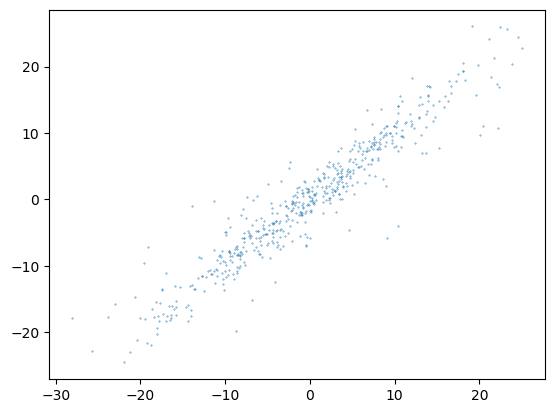

In [22]:
i += 1
scatter(4 .* tclasses[1:end, i], 4 .* predictions[1:end, i], s= 0.1)
show()
#println(4 * sum(abs.(tclasses[1:end, i] .+ predictions[1:end, i])))
#print(4 * sum(abs.(tclasses[1:end, i] .- predictions[1:end, i])))

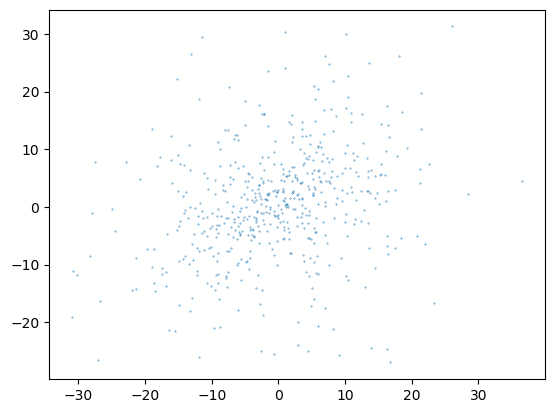

-520.0468

In [327]:
i += 1
scatter(4 .* tclasses[1:end, i], 4 .* predictions[1:end, i], s= 0.1)
show()

print(4 * sum(tclasses[1:end, i] .- predictions[1:end, i]))

In [35]:
sort(reshape(4 .* abs.(tclasses[1:end, 1:3] .- predictions[1:end, :]), (1005)))[Int(round(.95 * 1005))]

9.086005f0

In [23]:
network_parallel.model.evaluate((adata, tclasses[:, 4:end]), tclasses[:, 1:3])

whoop
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 2)  0           lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
____

0.9228076667927984

In [336]:
network_parallel.model.evaluate((data, classes[:, 4:end]), classes[:, 1:3])

2010/2010 [==============================] - 3s 1ms/step


5.795411590082728

In [11]:
importlib = pyimport("importlib")

PyObject <module 'importlib' from '/home/hastings/anaconda3/envs/stylegan/lib/python3.6/importlib/__init__.py'>

35127296-element Array{Float64,1}:
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
 -0.5                
  ⋮                  
  0.36602229172068157
  0.3660235070056443 
  0.36602389000737445
  0.3660242280328997 
  0.36602449106517804
  0.36602453163063087
  0.36602844827714276
  0.3660295943967151 
  0.36603019177683815
  0.36603563428147534
  0.36603920827165   
  0.3660474140444886 

In [22]:
function run_progressive_test(annotated_image)
    image = annotated_image.image
    an = annotated_image.annotation
    #image.array .= reverse(image.array, dims=1)
    

    s = [
        generate_sample_deterministic(
            image, 
            origin_by_height(an, 50) .+ 35 .* upright[:, 1], 
            origin_by_height(an, 50 + t) .+ 35 .* upright[:, 1], 
            upright, 
            upright
        )
        for t = 0:1:70
    ]

    rdata, rclasses = samples_to_dataset(s)
    rdata = approx_ultrasound(rdata)
    return rdata, rclasses
end

run_progressive_test (generic function with 1 method)

In [167]:
rdata, rclasses = run_progressive_test(t_annotated_images[2])
res = network_parallel.model.predict((rdata, rclasses[:, 4:end]))

71×3 Array{Float32,2}:
 0.185083  0.228744  -0.361933
 0.127261  0.353595  -0.323941
 0.183828  0.749797  -0.414685
 0.247134  0.77641   -0.226544
 0.412437  1.00478   -0.448118
 0.440571  1.47191   -0.323122
 0.437917  1.65983   -0.297431
 0.618242  2.02179   -0.467998
 0.655808  2.65005   -0.66905 
 0.595461  2.80937   -0.722084
 0.757129  3.06379   -0.74609 
 0.931369  3.04114   -0.678918
 1.23711   3.42653   -0.891476
 ⋮                            
 1.52654   4.57084   -1.45149 
 1.13369   4.66538   -1.9394  
 1.20519   4.80381   -1.55684 
 1.30605   4.62901   -1.82292 
 1.28538   4.84771   -1.63651 
 1.43754   5.53176   -1.43724 
 1.19122   5.96395   -1.64247 
 1.61301   6.21548   -1.67793 
 1.30292   6.39003   -1.69488 
 1.0303    5.99571   -1.6587  
 1.33067   5.99991   -1.91627 
 1.29569   6.38142   -1.71501 

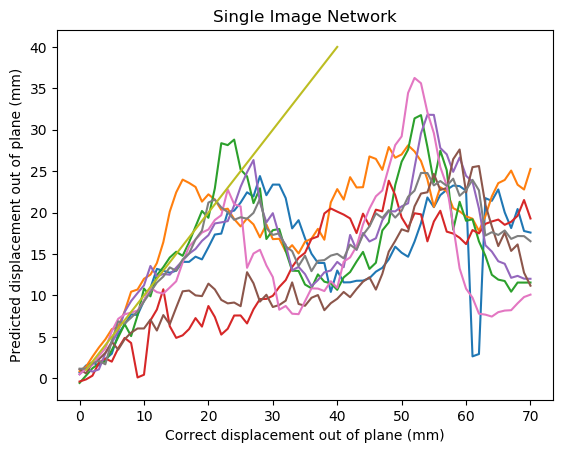

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f686733d400>

In [26]:
for an_im in t_annotated_images
    adata, rclasses = run_progressive_test(an_im)
    res = network_parallel.model.predict((adata, rclasses[:, 4:end]))
    plot(res[:, 2].* 4)
end
title("Single Image Network")
xlabel("Correct displacement out of plane (mm)")
ylabel("Predicted displacement out of plane (mm)")
plot([1, 40], [1, 40])
a

In [164]:
#t_annotated_images[1].image.array .= reverse(t_annotated_images[1].image.array, dims=1)

223×512×512 Array{Int16,3}:
[:, :, 1] =
 -1024  -1024  -1024  -1024  -1024  …  -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024  …  -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024  …  -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
 -1024  -1024  -1024  -1024  -1024     -1024  -1024  -1024  -1024  -1024
     ⋮     

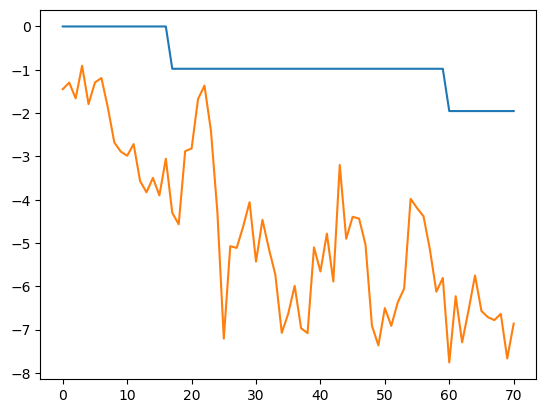

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8bf9b7fbe0>

In [175]:
plot(rclasses[:, 3].* 4)
plot(res[:, 3].* 4)

In [43]:
function approx_ultrasound(y)
    y = copy(y)
    #y .+= 1000
    #y[:, :, 1:20,:].= .8
    y *= 2000
    
    y[:, :, 1:end - 1, :] .= abs.(1 .- y[:, :, 2:end, :] ./ y[:, :, 1:end - 1, :])
    y[:, :, end, :] .= 0
    #return y
    denominator = cumsum(y, dims=3) .+ 0.01
    #return denominator
    return .5 .+ .1 .* max.(-10, log.(abs.( y ./ 4 .^ denominator .+ 0.0001 .* abs.(randn(size(y))))))
end

approx_ultrasound (generic function with 1 method)

In [44]:
@time a = approx_ultrasound(tdata)

  3.352569 seconds (1.85 M allocations: 1.516 GiB, 4.96% gc time)


536×128×128×4 Array{Float64,4}:
[:, :, 1, 1] =
  0.0776325   0.291851    0.311109    …   0.222936    0.282253    0.35006   
  0.123822    0.075359    0.050444        0.0543024   0.084198   -0.112493  
  0.304164    0.326532    0.0997144       0.0275027   0.098819    0.0361698 
 -0.131284   -0.111526    0.0186107      -0.110395   -0.0990993   0.00972159
  0.214418    0.330326    0.365934        0.365616    0.341175    0.232708  
  0.0883616   0.113179    0.118331    …   0.364515    0.34243     0.0922677 
  0.167069    0.123241    0.0927823      -0.0697642  -0.0713599   0.0115019 
  0.071363    0.15698     0.166852        0.358508    0.33316     0.162402  
  0.125796    0.119449    0.102276        0.0738281   0.0515281   0.11084   
  0.146492    0.118167    0.0499622       0.242845    0.252371    0.250066  
 -0.0233992   0.0996403   0.138658    …   0.277937    0.240831    0.107665  
 -0.186177   -0.0972108   0.00596493      0.160718    0.163981    0.16234   
 -0.02902     0.066002    0.0

In [125]:
i = 0

0

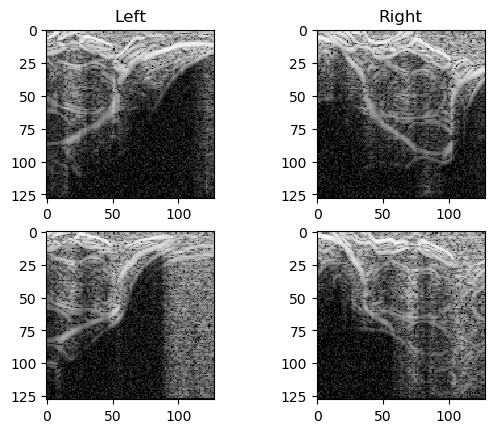

PyObject <matplotlib.image.AxesImage object at 0x7f8c075b6390>

In [170]:
i += 1
el = rdata[i, :, :, :]


fig, axs = subplots(2, 2)
axs[1, 1].imshow(el[:, :, 1]', cmap="gray")
axs[1, 1].set_title("Left")
axs[1, 2].imshow(el[:, :, 2]', cmap="gray")
axs[1, 2].set_title("Right")
axs[2, 1].imshow(el[:, :, 3]', cmap="gray")

axs[2, 2].imshow(el[:, :, 4]', cmap="gray")




In [313]:
fig.savefig("figures/sample_ultrasound.png", dpi=300)

In [319]:
tclasses[1, :] .* 4

6-element Array{Float32,1}:
  -2.2158318 
   5.569543  
 -10.356338  
  -3.312444  
   0.43843997
   0.6815026 

In [320]:
predictions[1, :] .* 4

3-element Array{Float32,1}:
  -2.661962 
   5.6683583
 -10.257261 

In [221]:
function filter_allblack(el)
    return sum(el .< -.4) / size(el[:])[1] > .5
end

function filter_none_allblack(dual_image_pair)
    return !any(filter_allblack(dual_image_pair[:, :, i]) for i = 1:4)
end

filter_none_allblack (generic function with 1 method)

In [216]:
distances = map(argmax(tdata .> .2; dims=3)) do elem
    return elem[3]
end

536×128×1×4 Array{Int64,4}:
[:, :, 1, 1] =
  1   1   1   1   1   1   1   1   1  …   1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1  …   1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
 21  21  21  20  20  20  20  20  20  …   5   5   5   4   4   4   4   4   4
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   

In [231]:
clean = [filter_none_allblack(adata[i, :, :, :]) for i = 1:size(adata)[1]]

536-element Array{Bool,1}:
 1
 1
 1
 1
 0
 0
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [233]:
adata_clean = adata[clean, :, :, :]
tclasses_clean = tclasses[clean, :, :, :]

485×6×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 -0.553958   1.39239   -2.58908    -0.828111    0.10961     0.170376 
 -1.43131   -4.83754    1.63705    -0.27903    -0.208545   -0.336352 
  2.93187   -0.429268   1.64668     0.0730382   0.48604    -0.145914 
  2.85056   -5.65551   -2.56389    -0.508136    0.155324    0.81298  
  2.02694   -0.351128   2.63371     1.01423     0.0811279  -0.509122 
 -2.14362    5.91146    0.143091    0.40322     0.462974   -0.168148 
 -0.557981   1.59173   -1.10235    -0.0481101  -0.704785   -0.350157 
  0.549338   4.06923   -0.755754   -0.178624    1.35149     0.129572 
 -1.88502    2.25519    2.93977     0.514967   -0.379973   -0.732509 
  3.89095    1.5796    -0.241029   -0.640625    0.184237    0.157512 
 -2.34784   -1.59828    1.93138    -0.465996    0.43291    -0.396712 
 -1.92016   -2.39927   -3.86814    -0.552139    0.299184    1.12669  
  2.34002    2.5854     1.0237      0.383355    0.138835   -0.954231 
  ⋮                                            

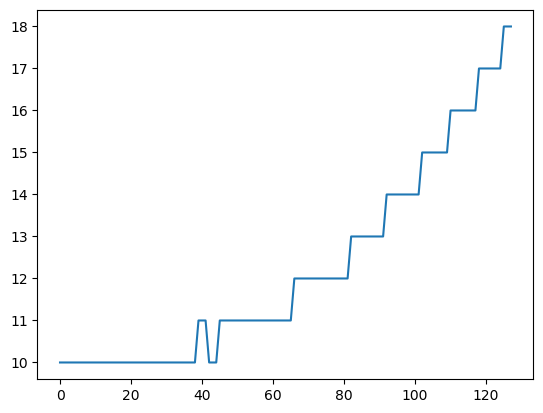

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8e1b9395c0>

In [210]:
plot(distances[39, :, 1, 3])

In [218]:
distances2 = sort(distances[:])

274432-element Array{Int64,1}:
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   1
   ⋮
 122
 123
 123
 124
 124
 125
 125
 126
 126
 127
 128
 128

In [219]:
distances2[Int64(round(.9 * length(distances2)))]

1

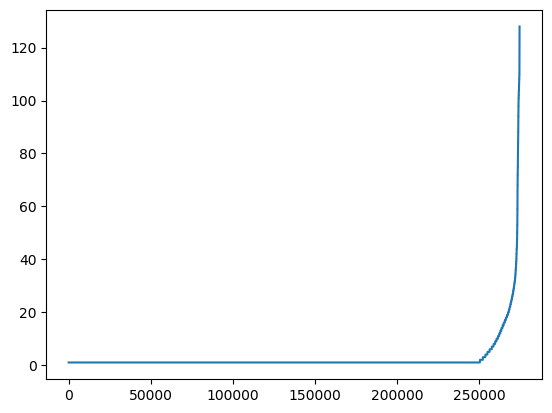

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8e0d51d6a0>

In [220]:
plt.plot(distances2)

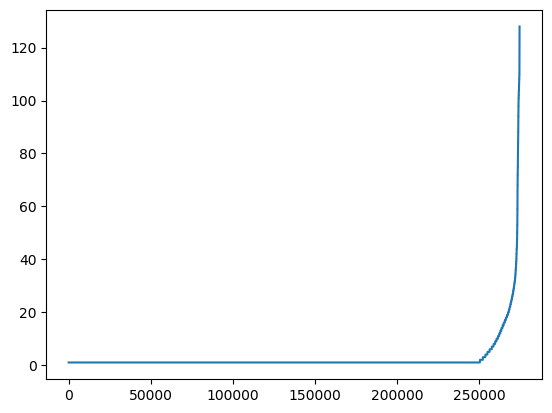

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8e0d478dd8>

In [221]:
plt.plot(distances2)

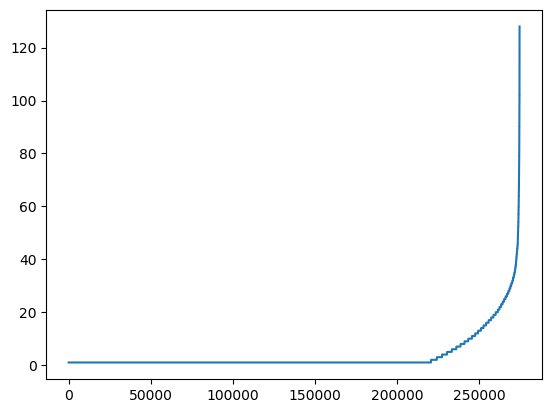

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8e220c6748>

In [197]:
plt.plot(distances2)

In [24]:
loadChildrensTransfoms = pyimport("loadChildrensTransforms")
constants = pyimport("constants")

PyObject <module 'constants' from '/media/data/hastings/ct-angledslice-align/constants.py'>

In [25]:
transforms1 = loadChildrensTransfoms.transforms
0

0

In [26]:
transforms2 = loadChildrensTransfoms.getTransforms(constants.volumes_path * "HultrasoundI2R/h-20180315_120336_ImageToReference.mha")
0

0

In [27]:
scale = 1 / norm(transforms1[1, 1, 1:3])
ts1 = transforms1 .* scale
basic_b = RotXYZ(sum(hcat(map([RotXYZ(ts1[i, 1:3, 1:3]) for i in 1:size(ts1)[1]]) do r
    [r.theta1, r.theta2, r.theta3]
                end ...), dims=2) ./ size(ts1)[1] ...)
goodcoords1 = cat([reshape(upright * inv(basic_b) * ts1[i, 1:3, 1:4], (1, 3, 4)) 
        for i in 1:size(ts1)[1]]..., dims = 1)
0

0

In [28]:
scale = 1 / norm(transforms2[1, 1, 1:3])
ts2 = transforms2 .* scale
basic_b = RotXYZ(sum(hcat(map([RotXYZ(ts2[i, 1:3, 1:3]) for i in 1:size(ts2)[1]]) do r
    [r.theta1, r.theta2, r.theta3]
                end ...), dims=2) ./ size(ts2)[1] ...)
goodcoords2 = cat([reshape(upright * inv(basic_b) * ts2[i, 1:3, 1:4], (1, 3, 4)) 
        for i in 1:size(ts2)[1]]..., dims = 1)
0
0

0

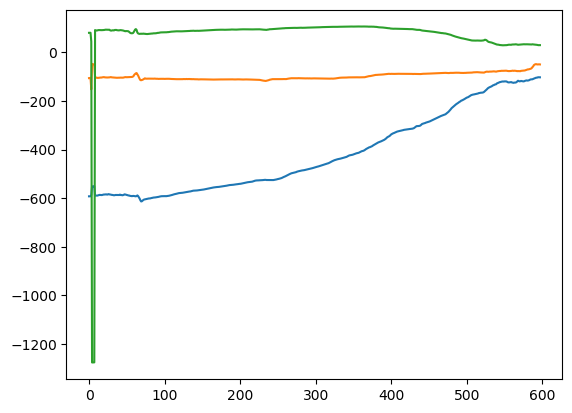

3-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbc027969b0>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc02796cc0>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc02796b70>

In [29]:
plot(goodcoords1[:, :, 4] ./ scale)

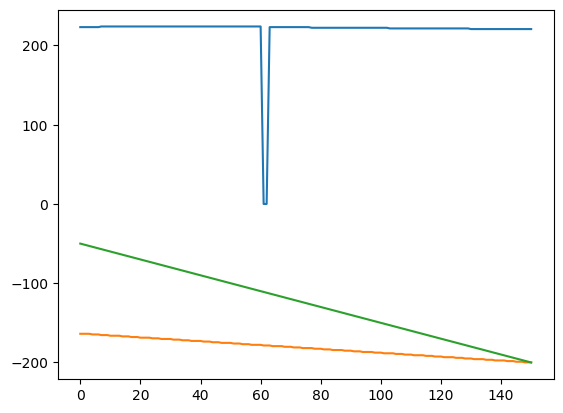

3-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbc0414c978>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc0414c160>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc0414c1d0>

In [30]:
image, an = t_annotated_images[1].image, t_annotated_images[1].annotation
s = [ 
        origin_by_height(an, 50 + t) .+ 35 .* upright[:, 1]         
        for t = 0:1:150
    ]
plot(s)

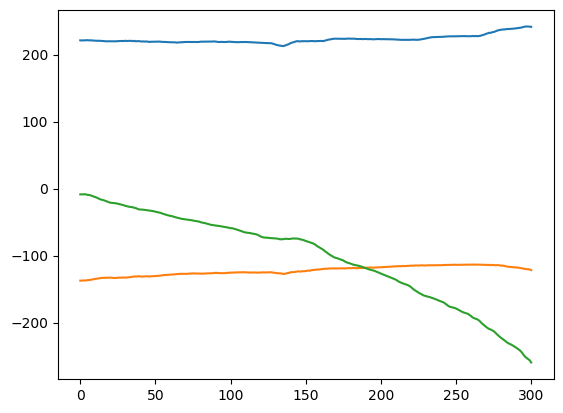

3-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbc027a0470>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc027a05c0>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc027a0710>

In [31]:
aligned = goodcoords1[:, :, 4]' ./ scale
aligned = [0 1 0 ; 0 0 1; -1 0 0] * aligned

aligned = RotXYZ(0, 0, 0) * aligned
aligned = aligned .+ [330; -220; -600]

aligned = aligned'
aligned = aligned[100:400, :]
plot(aligned)

In [32]:
gimage = GPUItkImage(image)

GPUItkImage(CuTexture{Float32,3,CuTextureArray{Float32,3}}(CuTextureArray{Float32,3}(Ptr{Nothing} @0x0000000021fb2970, (223, 512, 512)), 0x0000000000000003), Float32[1.0 0.0 0.0; 0.0 -1.0 0.0; 0.0 0.0 -1.0], Float32[0.8203125, 0.8203125, 1.0], Float32[512.0, 512.0, 223.0])

In [33]:
qq = 220

s = [
    generate_sample_deterministic(
        gimage, 
        aligned[t, :] .+ 35 .* upright[:, 1], 
        aligned[t+10, :] .+ 35 .* upright[:, 1], 
        goodcoords1[t, :, 1:3], 
        goodcoords1[t + 10, :, 1:3]
    )
    for t = 1:10:290
]
tdata, tclasses = samples_to_dataset(s)
adata = approx_ultrasound(tdata)
0

0

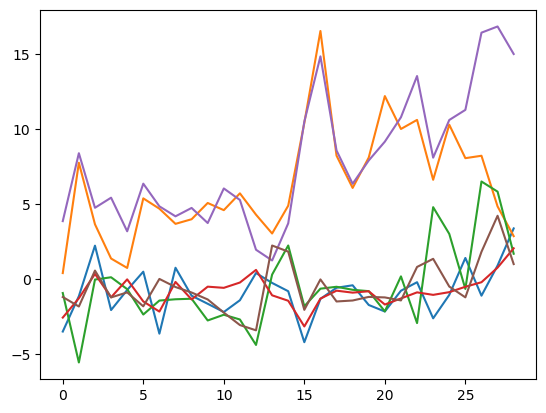

3-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbc02903160>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc029038d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fbc02903a20>

In [34]:
res = network_parallel.model.predict((adata, tclasses[:, 4:end]))
plot(res[:, 1:3].* 4)
plot(tclasses[:, 1:3] .* 4)

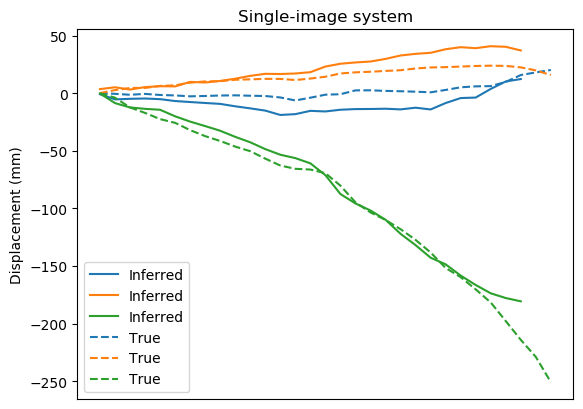

PyObject Text(24.0, 0.5, 'Displacement (mm)')

In [40]:
plot(cumsum(res[:, 1:3] * goodcoords1[10, 1:3, 1:3]', dims=1) .* 4, label="Inferred")
gca().set_prop_cycle(nothing)
plot(aligned[1:10:end, :] .- aligned[1:1, :], "--", label="True")
legend()
tick_params(
    axis="x",          # changes apply to the x-axis
    which="both",      # both major and minor ticks are affected
    bottom=false,      # ticks along the bottom edge are off
    top=false,         # ticks along the top edge are off
    labelbottom=false)
title("Single-image system")
ylabel("Displacement (mm)")

In [ ]:
nothi